Importando coisas

In [1]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

Declarando variáveis (que não tem valor definido no artigo)

In [2]:
T = 100
N2 = 1
N1 = 2
Z = 5
P1 = 8
P2 = 10

Declarando antecedentes e consequentes (universos)

In [3]:
bTime = ctrl.Antecedent(np.arange(0, 5*T, 1), 'buffering time')
bTimeDifferential = ctrl.Antecedent(np.arange(-2*T, 5*T, 1), 'buffering time differential')
qualityDifferential = ctrl.Consequent(np.arange(0, 10, 0.1), 'increase/reduce bitrate for next segment')

Montando membership functions + vendo resultados

d:\Documentos\UNB\2021-1\TR2\Trabalho Final\pydash\venv\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
d:\Documentos\UNB\2021-1\TR2\Trabalho Final\pydash\venv\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
d:\Documentos\UNB\2021-1\TR2\Trabalho Final\pydash\venv\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


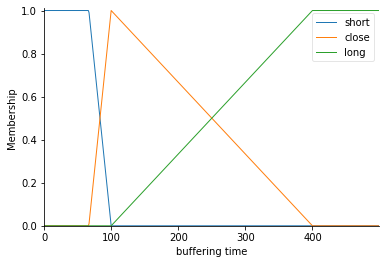

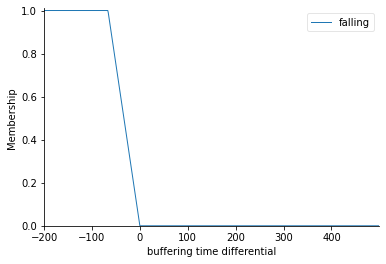

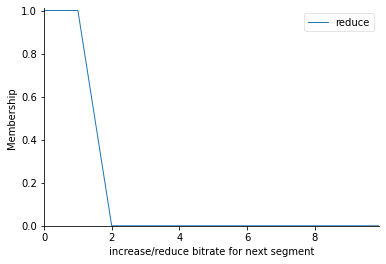

In [4]:
bTime['short'] = fuzz.trapmf(bTime.universe, [0,0,(2*T/3),T])
bTime['close'] = fuzz.trapmf(bTime.universe, [(2*T/3),T,T,4*T])
bTime['long'] = fuzz.trapmf(bTime.universe, [T,4*T,5*T,5*T])

bTimeDifferential['falling'] = fuzz.trapmf(bTimeDifferential.universe, [-2*T,-2*T,(-2*T/3),0])

qualityDifferential['reduce'] = fuzz.trapmf(qualityDifferential.universe, [0,0,N2,N1])

bTime.view()
bTimeDifferential.view()
qualityDifferential.view()
#TODO completar

Montando regras

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

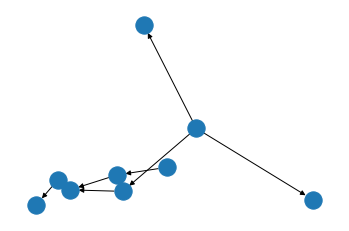

In [5]:
rule1 = ctrl.Rule(bTime['short'] & bTimeDifferential['falling'], qualityDifferential['reduce'])

rule1.view()

# TODO completar

Declarando/Configurando o sistema de controle

In [6]:
FDASHControl = ctrl.ControlSystem([rule1])
FDASH = ctrl.ControlSystemSimulation(FDASHControl)

Calculando saída/mostrando exemplo

0.9629870129870132


d:\Documentos\UNB\2021-1\TR2\Trabalho Final\pydash\venv\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


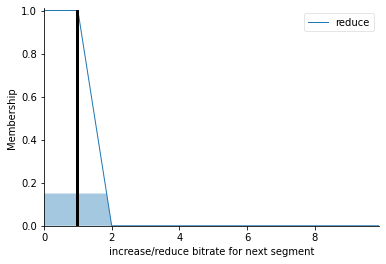

In [7]:
FDASH.input['buffering time'] = 90
FDASH.input['buffering time differential'] = -10

FDASH.compute()

print(FDASH.output['increase/reduce bitrate for next segment'])
qualityDifferential.view(sim=FDASH)